# Gradient Boost Model (Preprocessing)

In [5]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from collections import Counter


from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [6]:
#LOAD DATASET (data is already cleaned from notebook.ipynb)

song_df = pd.read_csv("processed_song_data.csv")

song_df.head()

,Track Name,Artist Name(s),Album Name,Album Artist Name(s),Explicit,age,artist_name,dating,family/gospel,genre,...,feelings,light/visual_perceptions,like/girls,movement/places,music,obscene,sadness,shake_the_audience,mood_%,mood
0,Justified & Ancient - Stand by the Jams,The KLF,Songs Collection,The KLF,False,1.0,mukesh,0.000598,0.048857,pop,...,0.117175,0.000598,0.000598,0.000598,0.039288,0.000598,0.380299,0.000598,0.426354,Neutral
1,I Know You Want Me (Calle Ocho),Pitbull,Pitbull Starring In Rebelution,Pitbull,False,1.0,'frankie laine',0.035537,0.027007,pop,...,0.001284,0.212681,0.001284,0.001284,0.118034,0.001284,0.001284,0.001284,0.770510,High Emotion
2,From the Bottom of My Broken Heart,Britney Spears,...Baby One More Time (Digital Deluxe Version),Britney Spears,False,1.0,'johnnie ray',0.002770,0.002770,pop,...,0.225422,0.002770,0.002770,0.002770,0.323794,0.002770,0.002770,0.002770,0.683601,High Emotion
3,Apeman - 2014 Remastered Version,The Kinks,"Lola vs. Powerman and the Moneygoround, Pt. On...",The Kinks,False,1.0,'prez prado',0.048249,0.001548,pop,...,0.001548,0.001548,0.081132,0.129250,0.001548,0.001548,0.225889,0.021500,0.604193,High Emotion
4,You Can't Always Get What You Want,The Rolling Stones,Let It Bleed,The Rolling Stones,False,1.0,'giorgos papadopoulos',0.001350,0.001350,pop,...,0.001350,0.001350,0.001350,0.001350,0.001350,0.001350,0.068800,0.001350,0.523334,Neutral


In [7]:
# Step 4: Feature Extraction
# split data into features and labels.
song_X = song_df.drop(columns=[
    # these are y variables
    'mood', 'mood_%',
    # these are too specific and may lead to overfitting
    'Track Name', 'Artist Name(s)', 'Album Name', 'Album Artist Name(s)', 'artist_name', 'track_name',
    # these are directly used to calculate mood, so to prevent data leakage we will drop them
    "Energy", "Valence", "sadness"
])

song_y = song_df['mood']

In [8]:
# encode labels

# Select categorical columns
categorical_columns = ["genre", "topic"]
categorical_features = song_X[categorical_columns]

# OneHotEncode categorical features
onehot_encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='error')
onehot_encoded_features = onehot_encoder.fit_transform(categorical_features)

one_hot_encoded_df = pd.DataFrame(onehot_encoded_features, columns=onehot_encoder.get_feature_names_out(categorical_columns))

one_hot_encoded_df.head()

,genre_blues,genre_country,genre_jazz,genre_pop,genre_reggae,genre_rock,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
# Scale numerical features with Robust Scaler to prevent outliers
# Select numerical columns
numerical_columns = song_X.drop(columns=categorical_columns)

# scale features
robust_scaler = RobustScaler()
scaled_numerical_song_X = robust_scaler.fit_transform(numerical_columns)

# add scaled features back to dataset
song_df_scaled = pd.DataFrame(scaled_numerical_song_X, columns=numerical_columns.columns)

song_df_scaled.head()

,Explicit,age,dating,family/gospel,night/time,romantic,violence,world/life,Danceability,Key,...,Tempo,communication,family/spirtual,feelings,light/visual_perceptions,like/girls,movement/places,music,obscene,shake_the_audience
0,0.0,1.354839,-0.304616,13.753176,-0.020203,0.388631,0.325838,-0.021807,0.009088,2.831565,...,-10.050823,2.019382,-0.046505,3.715431,-0.020727,-0.036869,-0.021489,0.651982,-0.012583,-0.083452
1,0.0,1.354839,12.015053,7.412837,-0.009395,-0.010446,0.501583,2.284810,0.217088,-3.168435,...,5.536177,-0.010424,2.090158,-0.015152,3.409123,-0.011510,-0.008092,2.022035,-0.005493,-0.026053
2,0.0,1.354839,0.461240,0.379585,0.014036,3.956966,0.001404,-0.010494,0.069088,1.831565,...,-46.527823,1.918204,0.045345,7.199923,0.014399,0.043467,0.020954,5.601954,0.009878,0.098386
3,0.0,1.354839,16.497359,0.024956,-0.005229,10.338176,-0.005099,-0.016859,0.075088,3.831565,...,-46.197823,-0.008380,-0.006335,-0.006644,-0.005364,2.941837,2.492491,-0.004644,-0.002760,1.666475
4,0.0,1.354839,-0.039654,-0.032634,-0.008358,11.647211,-0.006155,2.151139,-0.288912,-5.168435,...,-35.690823,-0.009915,1.186473,-0.013032,-0.008574,-0.009075,-0.006805,-0.008096,-0.004812,-0.020542


In [10]:
# combine scaled numerical features and onehot encoded features
processed_song_X = pd.concat([song_df_scaled, one_hot_encoded_df], axis=1)
print(processed_song_X.shape)
processed_song_X.head()

(27866, 38)


,Explicit,age,dating,family/gospel,night/time,romantic,violence,world/life,Danceability,Key,...,genre_pop,genre_reggae,genre_rock,topic_music,topic_night/time,topic_obscene,topic_romantic,topic_sadness,topic_violence,topic_world/life
0,0.0,1.354839,-0.304616,13.753176,-0.020203,0.388631,0.325838,-0.021807,0.009088,2.831565,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.354839,12.015053,7.412837,-0.009395,-0.010446,0.501583,2.284810,0.217088,-3.168435,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.354839,0.461240,0.379585,0.014036,3.956966,0.001404,-0.010494,0.069088,1.831565,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.354839,16.497359,0.024956,-0.005229,10.338176,-0.005099,-0.016859,0.075088,3.831565,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.354839,-0.039654,-0.032634,-0.008358,11.647211,-0.006155,2.151139,-0.288912,-5.168435,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
LABELS = ["High Emotion", "Neutral", "Low Emotion"]

In [11]:
# Split the dataset into training (60%), validation (20%), and test (20%) sets

X_train, X_test, y_train, y_test = train_test_split(processed_song_X, song_y, test_size=0.2, random_state=42, stratify=song_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

# Gradient Boost(Default)


In [12]:

# create gradient boost model with default parameters
gradient_boost_model = GradientBoostingClassifier(random_state=42)

# Train the Default Gradient Boost Model
gradient_boost_model.fit(X_train, y_train)


# predict on test set
gradient_boost_model_pred = gradient_boost_model.predict(X_test)


In [13]:
# evaluate model performance on validation set
gradient_boost_model_eval = gradient_boost_model.score(X_val, y_val)
print(f"Gradient Model Default Performance on Validation Set: {gradient_boost_model_eval}")

Gradient Model Default Performance on Validation Set: 0.7213350080746456


In [14]:
# print classification report before tuning hyperparameters
print("Classification Report (Before Tuning Hyperparameters):")
print(classification_report(y_test, gradient_boost_model_pred))

Classification Report (Before Tuning Hyperparameters):
              precision    recall  f1-score   support

High Emotion       0.72      0.95      0.82      2932
 Low Emotion       0.69      0.26      0.38       373
     Neutral       0.74      0.52      0.61      2269

    accuracy                           0.73      5574
   macro avg       0.72      0.58      0.60      5574
weighted avg       0.73      0.73      0.71      5574



In [15]:
# list top 10 features importance
feature_importance = dict(zip(processed_song_X.columns, gradient_boost_model.feature_importances_))
top_10_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]

print("Gradient Boost Model Default Top 10 Features Importance:")
for feature, importance in top_10_features:
    print(f"{feature}: {importance}")

Gradient Boost Model Default Top 10 Features Importance:
topic_sadness: 0.5765758991269454
Danceability: 0.08370312523742462
Acousticness: 0.05965903508113191
obscene: 0.037439355623338166
Speechiness: 0.03661542667133777
Loudness: 0.03175820456753257
Tempo: 0.02056184813952735
communication: 0.01696313524135364
movement/places: 0.016649208768010692
Liveness: 0.014290234067793135


In [16]:
# save the model
import pickle

with open('models/gradient_boost_model.pkl', 'wb') as f:
    pickle.dump(gradient_boost_model, f)

#### Optimze Default Gradient Boost Model

In [17]:
# Tune hyperparameters with random search and record best score
# define parameter grid to search
# using random search because of large dataset
# random search over learning_rate, n_estimators, max_depth
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [50,100, 200],
    'max_depth': [5, 10, 15],
}

# create random search object
search_gradient_model = GradientBoostingClassifier(random_state=42)

"""
Note using StratifiedKFold with 3 folds and scoring = 'f1_weighted' due to imbalanced dataset
"""

# perform random search
stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
gradient_random_search = (RandomizedSearchCV(search_gradient_model, param_distributions=param_grid, n_iter=3,
                                n_jobs = -1, cv=stratified_cv, scoring='f1_weighted'))
gradient_random_search.fit(X_train, y_train)

# print grid search results
print("Default Gradient Boost Model Best Parameters:", gradient_random_search.best_params_)


Default Gradient Boost Model Best Parameters: {'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.1}


In [18]:
# train optimized gradient boost model with best parameters
best_learning_rate = gradient_random_search.best_params_['learning_rate']
best_n_estimators = gradient_random_search.best_params_['n_estimators']
best_max_depth = gradient_random_search.best_params_['max_depth']

optimal_gradient_model = (GradientBoostingClassifier(learning_rate=best_learning_rate,
                                                     n_estimators=best_n_estimators, 
                                                     max_depth=best_max_depth, 
                                                     random_state=42))

# Train the Optimized Gradient Boost Model
optimal_gradient_model.fit(X_train, y_train)

# predict on test set
optimal_gradient_model_pred = optimal_gradient_model.predict(X_test)

# evaluate model performance on test set with validation set
optimal_gradient_model_eval = optimal_gradient_model.score(X_val, y_val)

print(f"Optimized Gradient Boost Model Performance on Validation Set: {optimal_gradient_model_eval} \n")

# print classification report after tuning hyperparameters
print("Classification Report after Tuning Hyperparameters:")
print(classification_report(y_test, optimal_gradient_model_pred))

Optimized Gradient Boost Model Performance on Validation Set: 0.7457383814821461 

Classification Report after Tuning Hyperparameters:
              precision    recall  f1-score   support

High Emotion       0.75      0.91      0.83      2932
 Low Emotion       0.66      0.32      0.43       373
     Neutral       0.73      0.60      0.66      2269

    accuracy                           0.74      5574
   macro avg       0.71      0.61      0.64      5574
weighted avg       0.74      0.74      0.73      5574



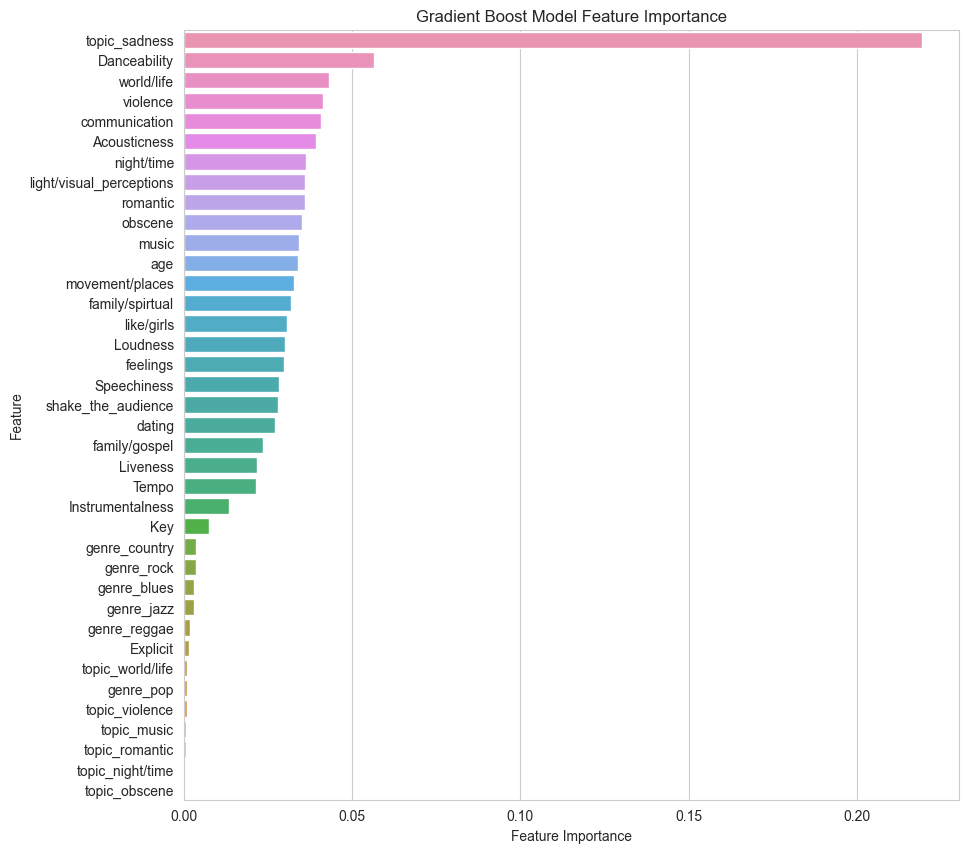

In [19]:
# Examine feature importance for gradient model

# create dataframe of feature importance
feature_importance_df = pd.DataFrame({"feature": processed_song_X.columns, "importance": optimal_gradient_model.feature_importances_})

# sort dataframe by importance
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

# plot feature importance
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=feature_importance_df, x="importance", y="feature", ax=ax, hue="importance", dodge=False)
ax.set_title("Gradient Boost Model Feature Importance")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("Feature")
ax.get_legend().remove()
plt.show()

## Confusion Matrix for Default and Optimize Gradient Boost

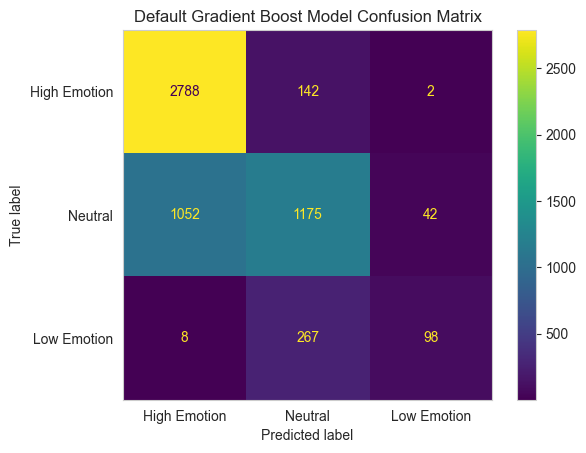

In [36]:
# confusion matrix for default gradient boost model
cm1 = confusion_matrix(y_test, gradient_boost_model_pred, labels=LABELS)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=LABELS)

# plot confusion matrix

disp1.plot(values_format='')
plt.title("Default Gradient Boost Model Confusion Matrix")
plt.grid(False)
plt.show()

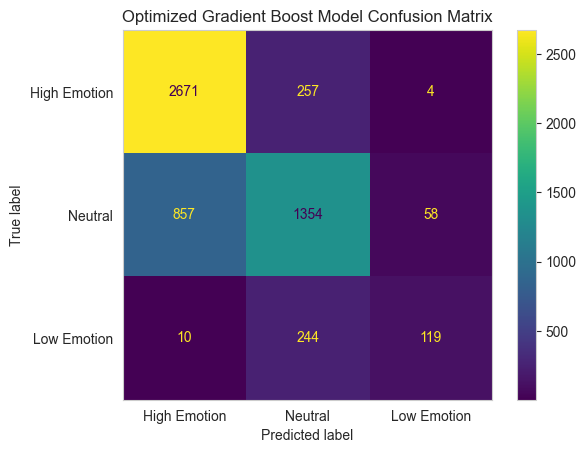

In [37]:
# visualize confusion matrix for optimized gradient boost model
cm2 = confusion_matrix(y_test, optimal_gradient_model_pred, labels=LABELS)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=LABELS)

# plot confusion matrix
disp2.plot(values_format='')
plt.title("Optimized Gradient Boost Model Confusion Matrix")
plt.grid(False)
plt.show()

In [22]:
# save the model
with open('models/optimal_gradient_boost_model.pkl', 'wb') as f:
    pickle.dump(optimal_gradient_model, f)

# Gradient Boost(Undersampling)

In [23]:
# perform random under sampling
rus = RandomUnderSampler(random_state=42)

# resample training data
emotion_X_train, emotion_y_train = rus.fit_resample(X_train, y_train)

In [24]:
# train gradient boost model with best parameters
rus_gradient_model = (GradientBoostingClassifier(learning_rate=best_learning_rate,
                                                n_estimators=best_n_estimators,
                                                 max_depth=best_max_depth,
                                                 random_state=42))

# Train the Gradient Boost Model
rus_gradient_model.fit(emotion_X_train, emotion_y_train)

# predict on test set

rus_gradient_model_pred = rus_gradient_model.predict(X_test)

# evaluate model performance on test set with validation set

rus_gradient_model_eval = rus_gradient_model.score(X_val, y_val)

print(f"Random Undersampling Gradient Boost Model Performance on Validation Set: {rus_gradient_model_eval} \n")

# print classification report after tuning hyperparameters
print(" Random Under Sampling Classification Report :")
print(classification_report(y_test, rus_gradient_model_pred))

Random Undersampling Gradient Boost Model Performance on Validation Set: 0.629822357796519 

 Random Under Sampling Classification Report :
              precision    recall  f1-score   support

High Emotion       0.75      0.79      0.77      2932
 Low Emotion       0.31      0.86      0.46       373
     Neutral       0.60      0.39      0.47      2269

    accuracy                           0.63      5574
   macro avg       0.55      0.68      0.57      5574
weighted avg       0.66      0.63      0.63      5574



## Confusion Matrix for UnderSampling


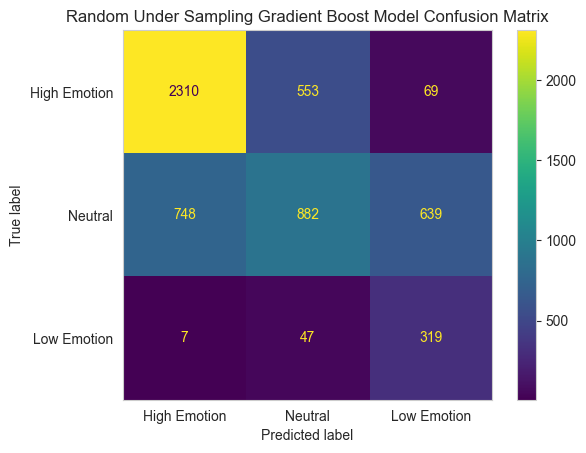

In [39]:
# confusion matrix for under sampling gradient boost model
cm3 = confusion_matrix(y_test, rus_gradient_model_pred, labels=LABELS)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=LABELS)

# plot confusion matrix

disp3.plot(values_format='')
plt.title("Random Under Sampling Gradient Boost Model Confusion Matrix")
plt.grid(False)
plt.show()

In [26]:
# save the model
with open('models/undersample_gradient_boost_model.pkl', 'wb') as f:
    pickle.dump(rus_gradient_model, f)

# Gradient Boost (OverSampling)

In [27]:
# perform random over sampling
ros = RandomOverSampler(random_state=42)

# resample training data
emotion_X_train_ros, emotion_y_train_ros = ros.fit_resample(X_train, y_train)

In [28]:
# train over sample gradient model with best parameters

oversample_gradient_model = (GradientBoostingClassifier(
                                                        learning_rate=best_learning_rate,
                                                        n_estimators=best_n_estimators,
                                                        max_depth=best_max_depth,
                                                        random_state=42))

# Train the Gradient Boost Model
oversample_gradient_model.fit(emotion_X_train_ros, emotion_y_train_ros)

# predict on test set

oversample_gradient_model_pred = oversample_gradient_model.predict(X_test)

# evaluate model performance on test set with validation set

oversample_gradient_model_eval = oversample_gradient_model.score(X_val, y_val)

print(f"Oversampling Gradient Boost Model Performance on Validation Set: {oversample_gradient_model_eval} \n")

# print classification report after tuning hyperparameters

print(" Random Over Sampling Classification Report :")

print(classification_report(y_test, oversample_gradient_model_pred))


Oversampling Gradient Boost Model Performance on Validation Set: 0.7441234523595909 

 Random Over Sampling Classification Report :
              precision    recall  f1-score   support

High Emotion       0.76      0.91      0.83      2932
 Low Emotion       0.64      0.39      0.49       373
     Neutral       0.74      0.61      0.67      2269

    accuracy                           0.75      5574
   macro avg       0.72      0.64      0.66      5574
weighted avg       0.75      0.75      0.74      5574



## Confusion Matrix for OverSampling

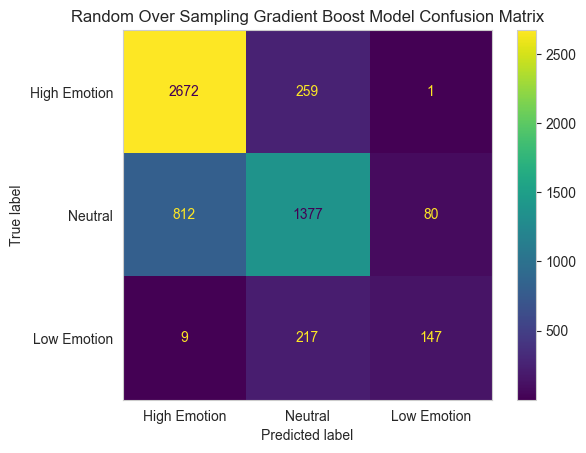

In [40]:
# confusion matrix for over sampling gradient model
cm4 = confusion_matrix(y_test, oversample_gradient_model_pred, labels=LABELS)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=LABELS)

# plot confusion matrix

disp4.plot(values_format='')
plt.title("Random Over Sampling Gradient Boost Model Confusion Matrix")
plt.grid(False)
plt.show()

In [30]:
# save the model
with open('models/oversample_gradient_boost_model.pkl', 'wb') as f:
    pickle.dump(oversample_gradient_model, f)

# Gradient Boost (SMOTE)

In [31]:
# Custom sampling strategy: Only oversample 'Low Emotion' class
sampling_strategy = {'Low Emotion': int(Counter(y_train)['Neutral']), 'High Emotion': Counter(y_train)['High Emotion'], 'Neutral': Counter(y_train)['Neutral']}

#perform SMOTE
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# resample training data
emotion_X_train_smote, emotion_y_train_smote = smote.fit_resample(X_train, y_train)

In [32]:
# train smote Gradient Boost model with best parameters

smote_gradient_model = (GradientBoostingClassifier(learning_rate=best_learning_rate,
                                                    n_estimators=best_n_estimators,
                                                    max_depth=best_max_depth,
                                                    random_state=42))

# Train the Gradient Boost Model
smote_gradient_model.fit(emotion_X_train_smote, emotion_y_train_smote)

# predict on test set

smote_gradient_model_pred = smote_gradient_model.predict(X_test)

# evaluate model performance on test set with validation set

smote_gradient_model_eval = smote_gradient_model.score(X_val, y_val)

print(f"SMOTE Gradient Boost Model Performance on Validation Set: {smote_gradient_model_eval} \n")

# print classification report after tuning hyperparameters

print(" SMOTE Classification Report :")

print(classification_report(y_test, smote_gradient_model_pred))

SMOTE Gradient Boost Model Performance on Validation Set: 0.7437645792212453 

 SMOTE Classification Report :
              precision    recall  f1-score   support

High Emotion       0.75      0.92      0.83      2932
 Low Emotion       0.56      0.49      0.52       373
     Neutral       0.75      0.55      0.63      2269

    accuracy                           0.74      5574
   macro avg       0.69      0.65      0.66      5574
weighted avg       0.74      0.74      0.73      5574



## Confusion Matrix for SMOTE

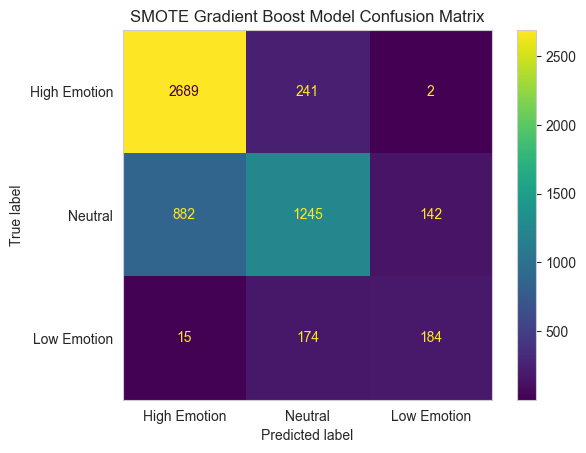

In [42]:
# confusion matrix for smote gradient boost model

cm5 = confusion_matrix(y_test, smote_gradient_model_pred, labels=LABELS)
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5, display_labels=LABELS)

# plot confusion matrix

disp5.plot(values_format='')
plt.title("SMOTE Gradient Boost Model Confusion Matrix")
plt.grid(False)
plt.show()

In [34]:
# save the model
with open('models/smote_gradient_boost_model.pkl', 'wb') as f:
    pickle.dump(smote_gradient_model, f)